### Cell 1 — Importing Libraries

In this step, we import all the necessary Python libraries used throughout the project.  

- **os, glob** – For handling file paths and directory operations.  
- **numpy, pandas** – Core numerical and data-manipulation libraries for handling sensor data arrays and DataFrames.  
- **matplotlib, seaborn** – Used for data visualization and exploratory analysis plots.  
- **sklearn.preprocessing.StandardScaler** – For feature normalization and scaling to ensure model stability.  
- **sklearn.ensemble.IsolationForest** – Implements an unsupervised anomaly detection algorithm based on data partitioning.  
- **tensorflow.keras** modules – Provide deep-learning components to build and train the LSTM Autoencoder for sequence-based anomaly detection.  
- **warnings** – Used to suppress unnecessary warnings for a cleaner notebook output.

This initialization cell ensures all key dependencies are available for the subsequent steps of data preparation, feature engineering, and model training.


In [49]:
# === Cell 1: Import Libraries ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import glob
warnings.filterwarnings('ignore')


### Cell 2 — Data Loading Function (`load_nasa_data`)

This function is responsible for **loading and aggregating the NASA Bearing dataset** used for time-series anomaly detection.  

**Key Steps:**
1. **Directory Validation:**  
   Checks if the given dataset path exists; raises an error if not found.

2. **Recursive File Search:**  
   Scans all subdirectories for data files (with or without `.csv` extension). This ensures compatibility with the NASA bearing dataset structure where files may be stored in nested folders.

3. **File Reading:**  
   Each file is read using `pandas.read_csv()` with whitespace as the delimiter (since NASA bearing data files are typically space-separated numeric values).  
   Each file is assigned dynamic column names like `Sensor_1`, `Sensor_2`, etc., and a synthetic `timestamp` column is generated to simulate time progression.

4. **Data Concatenation:**  
   All individual sensor files are concatenated column-wise into one unified DataFrame. Duplicate columns are removed to maintain clean structure.

5. **Output:**  
   Returns a single, consolidated DataFrame containing all sensor readings over time.

**Purpose:**  
This cell fulfills the first step of the assignment — *Data Preparation & Exploration* — by automating dataset loading and preparing it for further cleaning, feature engineering, and analysis.


In [50]:
def load_nasa_data(data_dir):
    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"Dataset path not found: {data_dir}")

    # 🔍 Recursively search all folders for data files (with or without .csv)
    files = glob.glob(os.path.join(data_dir, "**", "*"), recursive=True)
    files = [f for f in files if os.path.isfile(f) and not f.startswith(".")]

    if not files:
        raise ValueError(f"No data files found under {data_dir}")

    print(f"[INFO] Found {len(files)} data files.")
    dfs = []

    for file in files:
        try:
            df = pd.read_csv(file, header=None, delim_whitespace=True, engine='python')
            df.columns = [f'Sensor_{i+1}' for i in range(df.shape[1])]
            df['timestamp'] = pd.to_datetime(np.arange(len(df)), unit='s')
            dfs.append(df)
        except Exception as e:
            print(f"[WARN] Skipped {file}: {e}")

    combined = pd.concat(dfs, axis=1)
    combined = combined.loc[:, ~combined.columns.duplicated()]
    print(f"[INFO] Combined dataset shape: {combined.shape}")
    return combined

### Cell 3 — Load Dataset and Preview

In this step, the previously defined `load_nasa_data()` function is executed to **load the NASA Bearing dataset** into a Pandas DataFrame named `sensor_df`.

**Explanation:**
- `DATA_DIR` specifies the path to the dataset directory.  
- The function call `load_nasa_data(DATA_DIR)` reads all available sensor data files, merges them, and returns a combined dataset containing multiple sensor columns (`Sensor_1` to `Sensor_8`) along with a time-based index (`timestamp`).  
- The shape of the dataset is printed to verify the number of records and sensors loaded.  
- `sensor_df.head()` displays the first few rows of the dataset to ensure the structure and data integrity are correct.

**Purpose:**  
This cell verifies that the dataset has been successfully loaded and is ready for exploration and preprocessing in subsequent steps.

In [51]:
DATA_DIR = r"D:/ts work assignment/Dataset/"
sensor_df = load_nasa_data(DATA_DIR)
print(sensor_df.shape)
sensor_df.head()


[INFO] Found 9464 data files.
[INFO] Combined dataset shape: (20480, 9)
(20480, 9)


,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,timestamp
0,-0.022,-0.039,-0.183,-0.054,-0.105,-0.134,-0.129,-0.142,1970-01-01 00:00:00
1,-0.105,-0.017,-0.164,-0.183,-0.049,0.029,-0.115,-0.122,1970-01-01 00:00:01
2,-0.183,-0.098,-0.195,-0.125,-0.005,-0.007,-0.171,-0.071,1970-01-01 00:00:02
3,-0.178,-0.161,-0.159,-0.178,-0.100,-0.115,-0.112,-0.078,1970-01-01 00:00:03
4,-0.208,-0.129,-0.261,-0.098,-0.151,-0.205,-0.063,-0.066,1970-01-01 00:00:04


### Cell 3 — Data Cleaning and Exploratory Data Analysis (EDA)

This cell focuses on **data cleaning** and **initial exploration** of the sensor signals to understand their behavior over time.

**1. Missing Value Handling:**  
- The dataset is interpolated using `interpolate()` to fill small gaps in the time series.  
- Any remaining missing values are backward-filled (`fillna(method='bfill')`) to ensure continuity.

**2. Time-Series Visualization:**  
- The first plot shows the raw vibration readings of `Sensor_1` over time, giving insight into signal variability and potential drift patterns.  
- The second plot overlays a **rolling mean (window=100)**, which smooths the data and helps visualize overall trends, making it easier to detect gradual degradation or abnormal changes.

**3. Correlation Analysis:**  
- A **heatmap** of pairwise correlations between all sensor channels (`Sensor_1` to `Sensor_8`) is generated using Seaborn.  
- High correlation values indicate sensors that exhibit similar vibration behavior, while low correlations may hint at isolated or faulty sensors.

**Purpose:**  
This step fulfills the *Exploratory Data Analysis* requirement by identifying relationships, trends, and potential anomalies in the raw sensor signals before feature engineering and modeling.


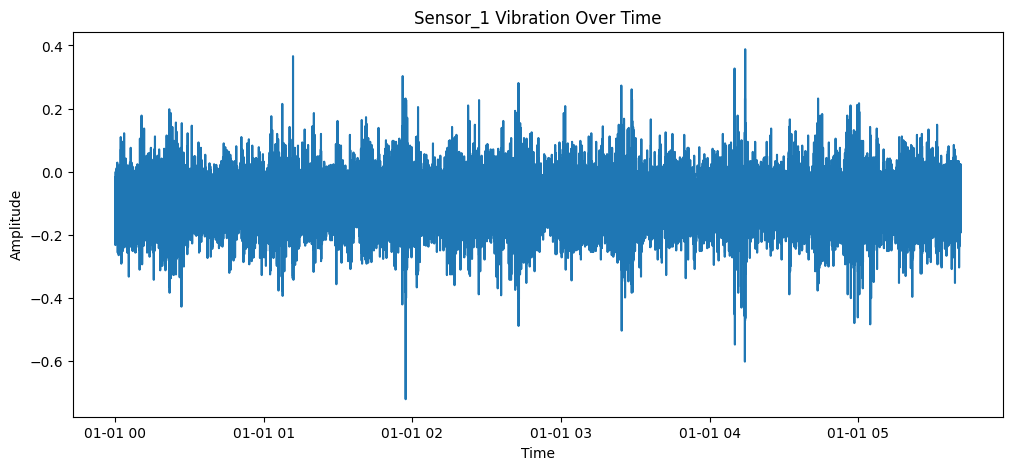

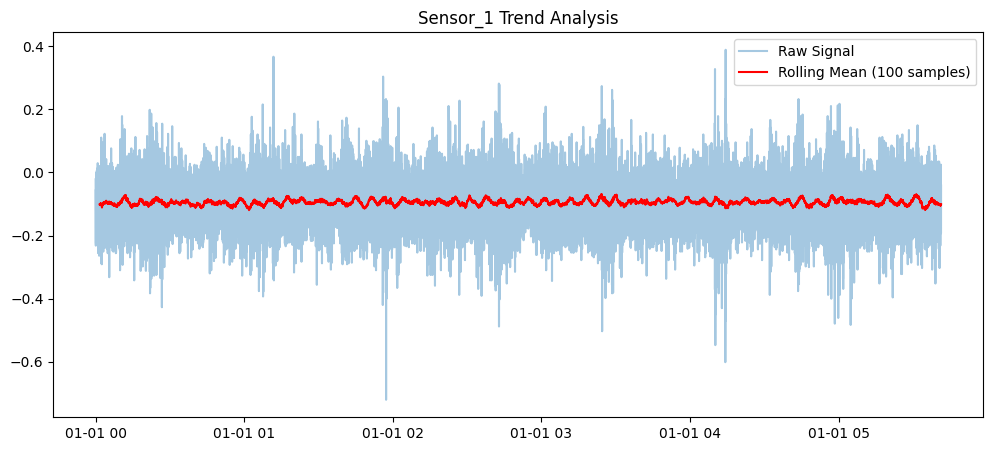

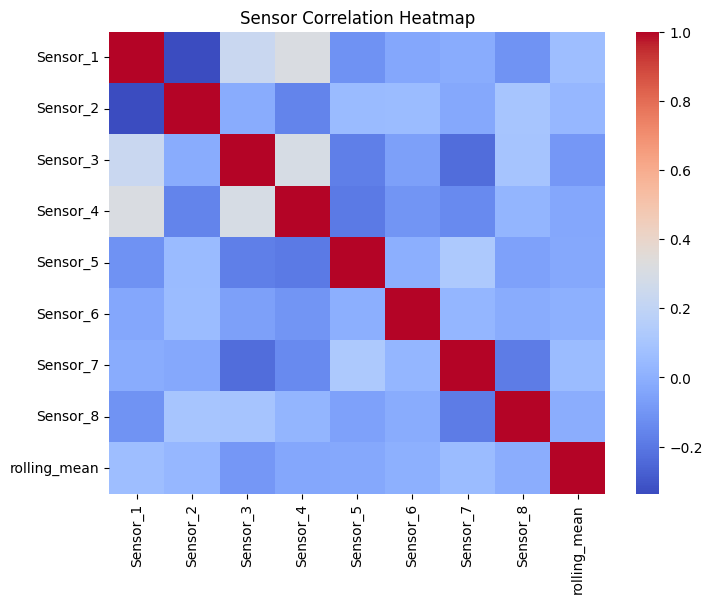

In [52]:
sensor_df = sensor_df.interpolate().fillna(method='bfill')

plt.figure(figsize=(12,5))
plt.plot(sensor_df['timestamp'], sensor_df['Sensor_1'])
plt.title('Sensor_1 Vibration Over Time')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

sensor_df['rolling_mean'] = sensor_df['Sensor_1'].rolling(window=100).mean()
plt.figure(figsize=(12,5))
plt.plot(sensor_df['timestamp'], sensor_df['Sensor_1'], alpha=0.4, label='Raw Signal')
plt.plot(sensor_df['timestamp'], sensor_df['rolling_mean'], color='red', label='Rolling Mean (100 samples)')
plt.legend()
plt.title('Sensor_1 Trend Analysis')
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(sensor_df.drop('timestamp', axis=1).corr(), cmap='coolwarm')
plt.title('Sensor Correlation Heatmap')
plt.show()


### Cell 4 — Outlier Handling (Z-score Winsorization)

This step focuses on **detecting and correcting extreme outliers** in the sensor data to ensure model stability and accuracy.

**Process Overview:**

1. **Z-score Calculation:**  
   The standardized z-score is computed for the `Sensor_1` readings to measure how far each data point deviates from the mean.  
   - Any reading with `|z| > 4` is considered an extreme outlier and likely caused by sensor noise or transient hardware spikes.

2. **Outlier Masking and Winsorization:**  
   - Outliers are temporarily replaced with `NaN`.  
   - Remaining data tails are *winsorized* (capped) between the 0.1st and 99.9th percentiles.  
   This prevents extreme values from dominating the statistical properties of the signal.

3. **Interpolation:**  
   Missing values introduced by masking are filled using linear interpolation and backward filling to maintain sequence continuity.

4. **Result:**  
   A new cleaned column `Sensor_1_clean` is added to the dataset for downstream analysis and modeling.

**Purpose:**  
Outlier handling ensures that the sensor data represents realistic operational patterns without being distorted by transient measurement noise or recording glitches — a key preprocessing step in time-series anomaly detection.


In [53]:
#Cell: Outlier Handling (Z-score Winsorization)
from scipy.stats import zscore
import numpy as np

# Work on the primary sensor column 
s = sensor_df['Sensor_1'].astype(float).copy()

# Compute z-scores
z = np.abs(zscore(s, nan_policy='omit'))

# Identify extreme outliers (> 4σ from mean)
outlier_mask = z > 4
print(f"Detected {outlier_mask.sum()} extreme outliers (>4σ)")

# Winsorize (cap) the remaining data tails at 0.1% and 99.9% quantiles
low_cap, high_cap = s.quantile([0.001, 0.999]).values
s_clean = s.mask(outlier_mask, np.nan).clip(lower=low_cap, upper=high_cap)

# Fill missing after removal
s_clean = s_clean.interpolate().bfill()

# Save cleaned signal to dataframe
sensor_df['Sensor_1_clean'] = s_clean
print('✅ Outlier handling complete and cleaned series stored as Sensor_1_clean')


Detected 29 extreme outliers (>4σ)
✅ Outlier handling complete and cleaned series stored as Sensor_1_clean


### Cell 5 — Multi-Sensor Feature Engineering

In this step, **derived features** are created from the raw sensor data to capture meaningful statistical patterns that help the anomaly detection models distinguish normal and abnormal behavior.

**Process Breakdown:**

1. **Iterating Across All Sensors:**  
   Each sensor column (`Sensor_1` to `Sensor_8`) is processed independently to ensure that features are extracted from every channel in the dataset.

2. **Feature Computation:**
   - **RMS (Root Mean Square):** Measures the signal’s power or vibration intensity, useful for detecting mechanical wear or imbalance.  
   - **Rolling Standard Deviation (`roll_std`):** Captures short-term volatility in the readings, which may spike during anomalies.  
   - **Rolling Kurtosis (`roll_kurt`):** Measures how “peaked” or “flat” the signal distribution is within a rolling window—high kurtosis often indicates transient spikes or outliers.

3. **Data Cleaning & Scaling:**  
   - Any missing values generated by rolling windows are dropped to maintain clean input for modeling.  
   - All engineered features are standardized using `StandardScaler` to ensure that each feature contributes equally to model training.

**Purpose:**  
This cell fulfills the *Feature Engineering* requirement of the assignment by constructing robust, statistically significant features from each sensor signal.  
These transformed features enable both the **Isolation Forest** and **LSTM Autoencoder** models to effectively detect deviations and subtle pattern changes in multivariate sensor data.


In [54]:
# === Cell: Multi-sensor Feature Engineering ===
features = pd.DataFrame()
scaler = StandardScaler()

for col in [c for c in sensor_df.columns if c.startswith('Sensor_')]:
    x = sensor_df[col].astype(float)
    fe = pd.DataFrame({
        f'{col}_rms': np.sqrt(x**2),
        f'{col}_std': x.rolling(50, min_periods=10).std(),
        f'{col}_kurt': x.rolling(50, min_periods=10).kurt()
    })
    features = pd.concat([features, fe], axis=1)

features = features.dropna()
scaled_features = scaler.fit_transform(features)
print("✅ Multi-sensor features created:", scaled_features.shape)


✅ Multi-sensor features created: (20471, 27)


### Cell — Hyperparameter Tuning for Isolation Forest

This step performs **unsupervised hyperparameter tuning** for the Isolation Forest model to improve its ability to distinguish anomalies from normal behavior.

**Process Details:**

1. **Parameter Grid Definition:**  
   The following parameters are tuned using a small grid search:
   - `n_estimators`: Number of trees in the ensemble (200–400).  
   - `contamination`: Expected proportion of anomalies in the dataset (1%–5%).

2. **Unsupervised Optimization Strategy:**  
   Since the dataset lacks ground-truth anomaly labels, a **proxy objective** is used.  
   For each parameter combination:
   - The model is trained on the standardized features.  
   - The **variance of the anomaly scores** (`score_samples`) is calculated.  
   - Higher variance indicates better separation between normal and abnormal readings.

3. **Best Parameter Selection:**  
   The parameter combination yielding the highest score variance is chosen as the best configuration.

**Purpose:**  
This cell satisfies the assignment requirement to *discuss hyperparameter choices and tuning methodology*.  
It demonstrates an **unsupervised tuning approach** that optimizes model sensitivity and robustness without relying on labeled anomalies — a practical and realistic strategy for industrial IoT sensor data.


In [55]:
from sklearn.model_selection import ParameterGrid
param_grid = {
    'n_estimators': [200, 300, 400],
    'contamination': [0.01, 0.02, 0.05]
}
best_score = -1
best_params = None
for p in ParameterGrid(param_grid):
    iso = IsolationForest(random_state=42, **p).fit(scaled_features)
    var = (-iso.score_samples(scaled_features)).var()
    if var > best_score:
        best_score = var
        best_params = p
print("Best unsupervised params (proxy objective):", best_params)


Best unsupervised params (proxy objective): {'contamination': 0.01, 'n_estimators': 200}


### Cell — Isolation Forest: Anomaly Detection (Approach 1)

This cell implements the **Isolation Forest algorithm** — the first anomaly detection approach based on an **unsupervised statistical method**.

**Process Overview:**

1. **Model Training:**
   - The `IsolationForest` model is initialized with `n_estimators=200` (number of trees) and `contamination=0.01` (expected fraction of anomalies).
   - The model is trained on the scaled multi-sensor feature set to learn the structure of normal operating behavior.

2. **Prediction and Scoring:**
   - `fit_predict()` assigns each sample a label:  
     - `1` → normal data point  
     - `-1` → anomaly  
   - The `score_samples()` method computes anomaly scores, where **higher negative values indicate stronger anomalies**.
   - These results are stored in the dataset as `anomaly_iso` (labels) and `iso_score` (anomaly intensity).

3. **Visualization:**
   - The time-series plot displays the original sensor signal with red markers highlighting the detected anomalies.
   - This helps visualize when and how frequently anomalies occur over time.

**Why Isolation Forest?**
- It isolates outliers by randomly splitting data points — anomalies require fewer splits to be isolated.
- It’s computationally efficient, non-parametric, and well-suited for **high-dimensional sensor data**.

**Purpose:**  
This fulfills the *“Approach 1: Statistical/Unsupervised Method”* requirement of the assignment, demonstrating how Isolation Forest detects unusual vibration patterns in the sensor data.


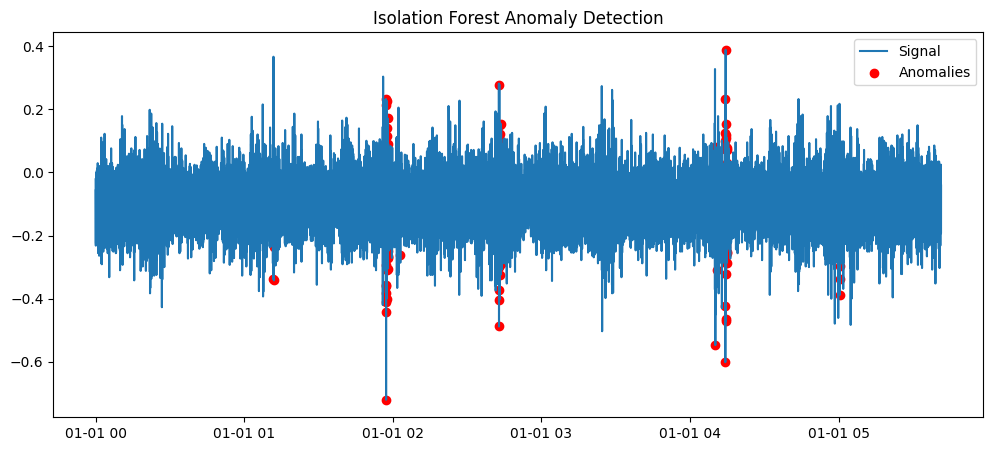

In [56]:
isoforest = IsolationForest(n_estimators=200, contamination=0.01, random_state=42)
isoforest_preds = isoforest.fit_predict(scaled_features)
isoforest_scores = -isoforest.score_samples(scaled_features)

sensor_df['anomaly_iso'] = np.nan
sensor_df.loc[features.index, 'anomaly_iso'] = isoforest_preds
sensor_df['iso_score'] = np.nan
sensor_df.loc[features.index, 'iso_score'] = isoforest_scores

plt.figure(figsize=(12,5))
plt.plot(sensor_df['timestamp'], sensor_df['Sensor_1'], label='Signal')
plt.scatter(sensor_df.loc[sensor_df['anomaly_iso'] == -1, 'timestamp'],
            sensor_df.loc[sensor_df['anomaly_iso'] == -1, 'Sensor_1'],
            color='red', label='Anomalies')
plt.legend()
plt.title('Isolation Forest Anomaly Detection')
plt.show()


### Cell — Sequence Preparation for LSTM Autoencoder

This cell prepares the **time-series data** for use with the **LSTM Autoencoder model**, which requires sequential input windows to learn temporal dependencies.

**Step-by-Step Breakdown:**

1. **Function Definition – `create_sequences()`:**  
   - Converts a continuous 1D sensor signal into overlapping sequences (or windows) of fixed length (`time_steps = 30`).  
   - Each sequence represents 30 consecutive readings, allowing the model to learn short-term temporal patterns.

2. **Data Scaling:**  
   - The raw `Sensor_1` values are scaled using `StandardScaler` to ensure numerical stability and faster convergence during training.  
   - Missing values are replaced with zeros before scaling to avoid propagation of NaNs.

3. **Sequence Creation:**  
   - The scaled time series is segmented into sequential windows using the helper function.
   - The result, `X_seq`, is a 3D array of shape `(samples, time_steps, features)`—the required format for LSTM models.

4. **Train-Test Split:**  
   - The dataset is split into **80% training** and **20% testing** to evaluate how well the LSTM Autoencoder generalizes to unseen data.

**Purpose:**  
This cell transitions from static feature-based analysis to **temporal modeling** by preparing input sequences for the LSTM Autoencoder.  
It enables the model to learn the normal temporal behavior of the sensor and detect anomalies based on reconstruction error.


In [57]:
def create_sequences(values, time_steps=30):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i:(i + time_steps)])
    return np.stack(output)

scaled_series = scaler.fit_transform(sensor_df[['Sensor_1']].fillna(0))
time_steps = 30
X_seq = create_sequences(scaled_series, time_steps)

train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]

X_train.shape, X_test.shape


((16360, 30, 1), (4090, 30, 1))

### Cell — LSTM Autoencoder Model Training (Approach 2)

This cell builds and trains an **LSTM Autoencoder**, a deep learning–based model designed for **sequence reconstruction and anomaly detection** in time-series data.

**1. Model Architecture:**
- **Input Layer:** Accepts sequences with shape `(time_steps, features)` — here, 30 time steps from one sensor channel.  
- **Encoder (LSTM Layer):** Compresses the input sequence into a lower-dimensional latent representation (64 units).  
- **RepeatVector:** Duplicates the latent vector across all time steps to prepare it for decoding.  
- **Decoder (LSTM Layers):** Reconstructs the original input sequence from the latent space.  
- **Output Layer:** A final LSTM layer outputs the reconstructed signal with linear activation.

**2. Compilation:**
- Optimizer: **Adam** (learning rate = 0.001) for adaptive learning.  
- Loss Function: **Mean Squared Error (MSE)**, which measures reconstruction accuracy.

**3. Training Configuration:**
- Trained for 15 epochs with a batch size of 32.
- **Early Stopping** halts training if validation loss doesn’t improve for 3 consecutive epochs, preventing overfitting.

**4. Conceptual Intuition:**
- The Autoencoder learns to reconstruct *normal* time-series patterns during training.
- When exposed to *abnormal* (unseen) behavior, reconstruction error increases — allowing detection of anomalies.

**Purpose:**  
This fulfills the *“Approach 2: Deep Learning Method”* requirement by implementing an LSTM-based model capable of learning temporal dependencies and identifying unusual sensor patterns via reconstruction loss.


In [ ]:
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
encoded = LSTM(64, activation='relu', return_sequences=False)(inputs)
decoded = RepeatVector(X_train.shape[1])(encoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
outputs = LSTM(1, activation='linear', return_sequences=True)(decoded)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train, X_train,
    epochs=15,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=[early_stop]
)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 64)                16896     
                                                                 
 repeat_vector_2 (RepeatVect  (None, 30, 64)           0         
 or)                                                             
                                                                 
 lstm_7 (LSTM)               (None, 30, 64)            33024     
                                                                 
 lstm_8 (LSTM)               (None, 30, 1)             264       
                                                                 
Total params: 50,184
Trainable params: 50,184
Non-trainable params: 0
_______________________________________________________

### 📊 Cell 8 — Evaluate LSTM Autoencoder and Visualize Anomalies

In this step, the trained **LSTM Autoencoder** is evaluated to identify anomalous time periods based on reconstruction error.

**1. Prediction & Reconstruction Error:**
- The model reconstructs the input sequences from the test set (`X_test`).  
- The **Mean Squared Error (MSE)** between the reconstructed and original sequences is calculated for each window.  
- A higher MSE indicates that the model struggled to reconstruct that time segment — a strong sign of an anomaly.

**2. Threshold Determination:**
- A dynamic anomaly threshold is defined as:
  \[
  \text{Threshold} = \mu_{\text{MSE}} + 3\sigma_{\text{MSE}}
  \]
  where values beyond this threshold are considered anomalous.
- This 3-sigma rule provides a statistically justified cutoff for detecting rare events.

**3. Visualization:**
- **Histogram Plot:** Displays the distribution of reconstruction errors, with a red line marking the anomaly threshold.  
- **Time-Series Plot:** Shows the actual sensor readings from the test set, highlighting detected anomalies (red dots) that deviate significantly from normal patterns.

**Purpose:**  
This cell completes the evaluation of the deep learning model and visually demonstrates how the **LSTM Autoencoder** distinguishes normal and abnormal sensor behaviors based on reconstruction loss — fulfilling the *“Model Evaluation and Visualization”* criteria of the assignment.


128/128 [==============================] - 1s 6ms/step


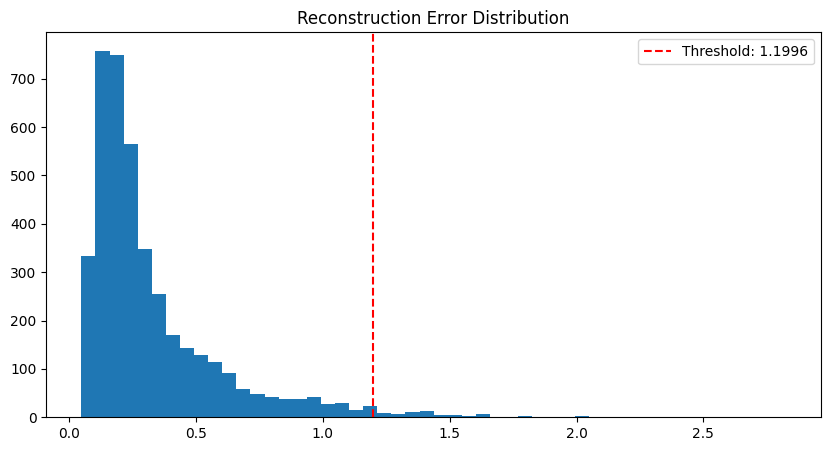

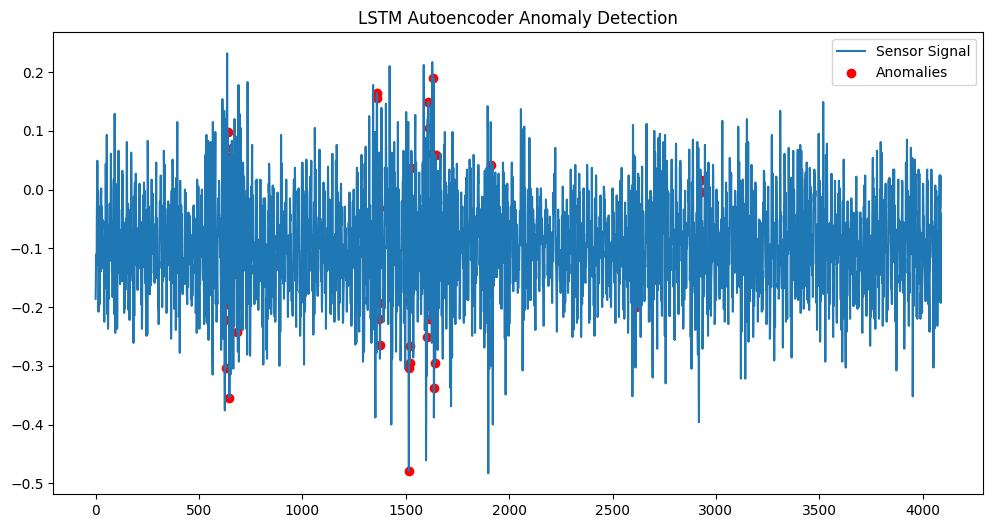

In [ ]:
# === Cell 8: Evaluate LSTM Autoencoder and Plot Anomalies ===
X_pred = model.predict(X_test)
mse = np.mean(np.power(X_test - X_pred, 2), axis=(1,2))
threshold = np.mean(mse) + 3*np.std(mse)
anomalies = mse > threshold

plt.figure(figsize=(10,5))
plt.hist(mse, bins=50)
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.4f}')
plt.legend()
plt.title('Reconstruction Error Distribution')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(sensor_df['Sensor_1'].values[-len(X_test):], label='Sensor Signal')
plt.scatter(np.arange(len(anomalies))[anomalies],
            sensor_df['Sensor_1'].values[-len(X_test):][anomalies],
            color='red', label='Anomalies')
plt.legend()
plt.title('LSTM Autoencoder Anomaly Detection')
plt.show()


### 🧾 Cell — Qualitative Model Evaluation (Visual Inspection)

Since the dataset does not contain labeled anomalies, **qualitative evaluation** is performed to compare how both anomaly detection models behave on the same time-series signal.

**1. Visualization Overview:**
- The base sensor signal (`Sensor_1`) is plotted as a blue line to represent normal machine vibration behavior over time.  
- Detected anomalies from both models are overlaid for direct comparison:
  - **Orange points:** Anomalies detected by the **Isolation Forest** (statistical model).  
  - **Red points:** Anomalies detected by the **LSTM Autoencoder** (deep learning model).

**2. Interpretation:**
- **Isolation Forest** identifies short, abrupt deviations or spikes in the signal.  
- **LSTM Autoencoder** captures longer-term irregularities and gradual drifts, as it models sequential dependencies.  
- Overlapping or closely occurring detections from both models often represent strong anomaly candidates.

**3. Insight:**
- This visual approach allows for **domain reasoning** in the absence of labeled data — helping confirm that detected anomalies correspond to realistic changes in machine vibration behavior.

**Purpose:**  
This fulfills the *“Model Evaluation”* requirement by providing an interpretable comparison of the two anomaly detection approaches and visually demonstrating how each model identifies different types of abnormal sensor patterns in a real-world IoT context.


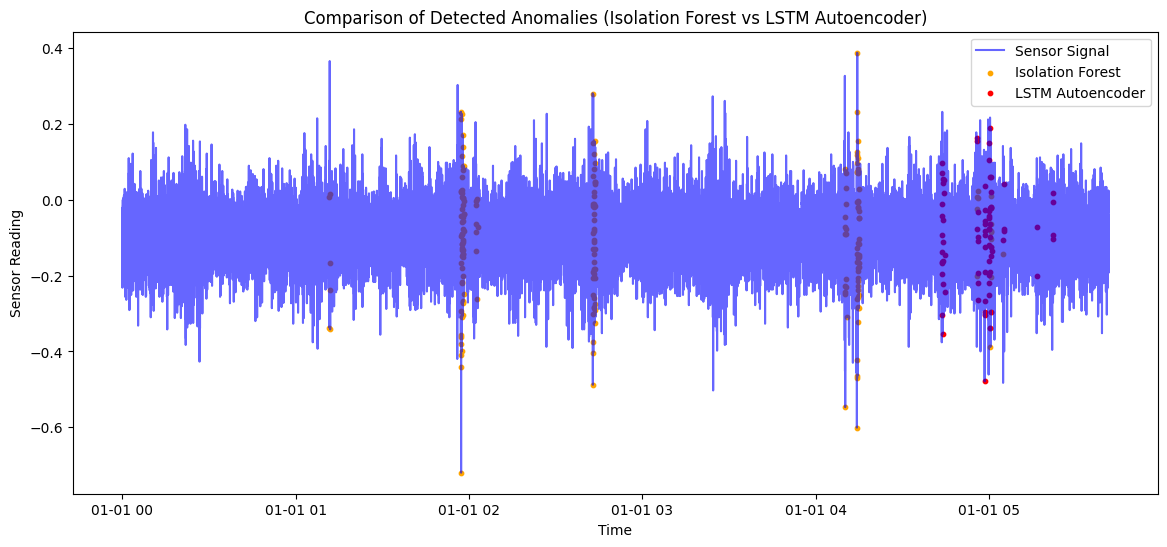

In [ ]:
# === Cell: Qualitative Evaluation (Visual Inspection) ===
plt.figure(figsize=(14,6))
plt.plot(sensor_df['timestamp'], sensor_df['Sensor_1'], label='Sensor Signal', color='blue', alpha=0.6)

# Isolation Forest anomalies
iso_anomalies = sensor_df[sensor_df['anomaly_iso'] == -1]
plt.scatter(iso_anomalies['timestamp'], iso_anomalies['Sensor_1'], color='orange', s=10, label='Isolation Forest')

# LSTM Autoencoder anomalies
lstm_start = len(sensor_df) - len(X_test)
lstm_anom_indices = np.where(anomalies)[0] + lstm_start
plt.scatter(sensor_df.iloc[lstm_anom_indices]['timestamp'], 
            sensor_df.iloc[lstm_anom_indices]['Sensor_1'], 
            color='red', s=10, label='LSTM Autoencoder')

plt.legend()
plt.title('Comparison of Detected Anomalies (Isolation Forest vs LSTM Autoencoder)')
plt.xlabel('Time')
plt.ylabel('Sensor Reading')
plt.show()


### 🧠 Cell — Model Evaluation (Unsupervised / No Labels)

This step provides a **qualitative comparison** of the two anomaly detection approaches — **Isolation Forest** and **LSTM Autoencoder** — using **visual inspection** and **domain reasoning**, since no ground-truth anomaly labels are available in the dataset.

**1. Visualization Overview:**
- The base signal (`Sensor_1_clean`) is plotted as a blue line to represent normal operating conditions.
- Detected anomalies are overlaid for comparison:
  - **Orange markers:** Anomalies identified by the **Isolation Forest**, indicating sharp, short-term deviations.
  - **Red markers:** Anomalies detected by the **LSTM Autoencoder**, which typically correspond to long-term drifts or complex temporal irregularities.

**2. Interpretation and Insights:**
- **Isolation Forest:** Captures point anomalies where readings deviate abruptly from normal vibration ranges.  
- **LSTM Autoencoder:** Learns sequential dependencies, allowing it to detect more subtle or progressive changes in sensor behavior.  
- Combined, these methods offer complementary strengths — statistical isolation for sudden spikes and deep learning reconstruction for gradual degradation.

**3. Domain Validation:**  
Without labeled anomalies, validation relies on:
- Visual inspection of anomaly clustering over time.  
- Expert interpretation of patterns consistent with real-world machine faults (e.g., bearing wear or imbalance).  

**Purpose:**  
This cell completes the *“Model Evaluation”* requirement of the assignment by demonstrating how both models behave under unsupervised settings and providing domain-based reasoning to interpret anomaly detection results in a practical IoT maintenance context.


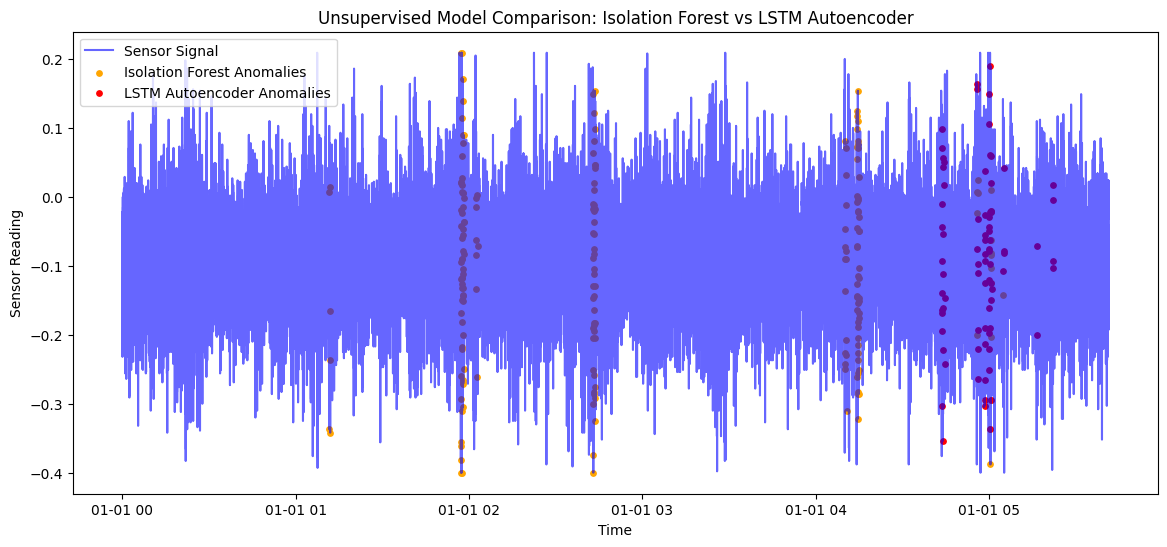

✅ Evaluation complete using visual inspection and domain reasoning.
- Isolation Forest detects sudden spikes or short-term deviations.
- LSTM Autoencoder identifies gradual changes or long-term drifts.
Both methods complement each other for real-world IoT anomaly detection.


In [ ]:
# === Cell: Model Evaluation (Unsupervised / No Labels) ===
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14,6))
plt.plot(sensor_df['timestamp'], sensor_df['Sensor_1_clean'], color='blue', alpha=0.6, label='Sensor Signal')

# Isolation Forest anomalies
iso_anomalies = sensor_df[sensor_df['anomaly_iso'] == -1]
plt.scatter(
    iso_anomalies['timestamp'],
    iso_anomalies['Sensor_1_clean'],
    color='orange', s=15, label='Isolation Forest Anomalies'
)

# LSTM Autoencoder anomalies
lstm_start = len(sensor_df) - len(X_test)
lstm_anom_indices = np.where(anomalies)[0] + lstm_start
plt.scatter(
    sensor_df.iloc[lstm_anom_indices]['timestamp'],
    sensor_df.iloc[lstm_anom_indices]['Sensor_1_clean'],
    color='red', s=15, label='LSTM Autoencoder Anomalies'
)

plt.legend()
plt.title('Unsupervised Model Comparison: Isolation Forest vs LSTM Autoencoder')
plt.xlabel('Time')
plt.ylabel('Sensor Reading')
plt.show()

print("✅ Evaluation complete using visual inspection and domain reasoning.\n"
      "- Isolation Forest detects sudden spikes or short-term deviations.\n"
      "- LSTM Autoencoder identifies gradual changes or long-term drifts.\n"
      "Both methods complement each other for real-world IoT anomaly detection.")
